In [52]:
# %load ../brainmix_register/registration.py
import sys
import os, glob
import numpy as np
from skimage import feature
from skimage import io
from skimage import transform as tf
import matplotlib.pyplot as plt
from skimage.color import gray2rgb


# -----------------Registration function-------------------------


def reg(src, dst):
    """Takes in a source and destination image and returns a
    registered destination (target) image.

    src: the reference image
    dst: the image to register
    """
    shifts, err, phasediff = feature.register_translation(src, dst, 1)
    tform = tf.AffineTransform(translation=shifts[::-1])
    reg_dst = tf.warp(dst, inverse_map=tform.inverse)
    print(shifts, err, phasediff)

    return reg_dst

# ----------------Stack function --------------------------------


def reg_iter(stack):
    """
    input: a stack of images and registers each one using the first
    image as the source.
    output: a registered stack.
    """
    src = stack[0]
    reg_stack = [reg(src, dst) for dst in stack]
    return reg_stack

# --------------View overlayed result--------------------------


def overlay_pics(src, dst):

    image0_ = src
    image1_ = dst

    def add_alpha(image, background=-1):
        """Add an alpha layer to the image.

        The alpha layer is set to 1 for foreground
        and 0 for background.
        """
        rgb = gray2rgb(image)
        alpha = (image != background)
        return np.dstack((rgb, alpha))

    image0_alpha = add_alpha(image0_)
    image1_alpha = add_alpha(image1_)

    merged = (image0_alpha + image1_alpha)
    alpha = merged[..., 3]

    # The summed alpha layers give us an indication of
    # how many images were combined to make up each
    # pixel.  Divide by the number of images to get
    # an average.
    merged /= np.maximum(alpha, 1)[..., np.newaxis]
    return merged

# ---------------main-------------------------------


def registration(img_stack):
    """input: ndarray of images
    ouput: ndarray of registered images
    """

    # assert len(img_stack) == 3  # Check that images are greyscale.
    reg_stack = reg_iter(img_stack)

    if not np.array_equal(img_stack[0], reg_stack[0]):
        print("destination image has been changed in registered stack.")
    # src and dst images should be different
    assert not np.array_equal(img_stack[0], reg_stack[1])
    return io.concatenate_images(reg_stack)

if __name__ == "__main__":
    # Check if running with version 2 or 3. If 2, use raw_input().
    # Currently, python 3 causes the script to exit.
    # TODO: if v. 3, then parse commandline arguments with input()
    # else, use raw_input().
    if sys.version_info >= (3,0):
        sys.stdout.write("Sorry, requires Python 2.x, not Python 3.x\n")
        sys.exit(1)
    
    if len(sys.argv) == 2: 
        inputDir = sys.argv[-1] 
        imageFiles = glob.glob(os.path.join(inputDir, '*.jpg'))
        imageVolume = io.ImageCollection(imageFiles, as_grey=True).concatenate()
        stack = imageVolume

        reg_stack = registration(stack)
        i = 0;
        for img in reg_stack:
            io.imsave('reg{}',img).format(i)
            i += 1
        sys.exit(1)


    elif len(sys.argv) > 2: 
        print("Script takes in one or zero arguments.")
        sys.exit(1)

    else: 
        inputDir = '../data/test/'
    
    # ------------------Create input ndarray------------------------
    imageFiles = glob.glob(os.path.join(inputDir, '*.jpg'))
    imageVolume = io.ImageCollection(imageFiles, as_grey=True).concatenate()
    stack = imageVolume

    reg_stack = registration(stack)

    print('stack is of type', type(stack))
    print('stack dimensions are', stack.shape)
    print('registered stack is of type', type(reg_stack))
    print('registered stack dimensions are', reg_stack.shape)

    merged = [overlay_pics(stack[0], img) for img in stack]
    merged_reg = [overlay_pics(reg_stack[0], img) for img in reg_stack]
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

    plt.gray()

    ax[0, 0].imshow(merged[0])
    ax[0, 0].axis('off')
    ax[0, 0].set_title('original 1-1')
    ax[0, 1].imshow(merged[1])
    ax[0, 1].axis('off')
    ax[0, 1].set_title('original 1-2')
    ax[0, 2].imshow(merged[2])
    ax[0, 2].axis('off')
    ax[0, 2].set_title('original 1-3')

    ax[1, 0].imshow(merged_reg[0])
    ax[1, 0].axis('off')
    ax[1, 0].set_title('registered 1-1')
    ax[1, 1].imshow(merged_reg[1])
    ax[1, 1].axis('off')
    ax[1, 1].set_title('registered 1-2')
    ax[1, 2].imshow(merged_reg[2])
    ax[1, 2].axis('off')
    ax[1, 2].set_title('registered 1-3')

    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                        top=0.9, bottom=0.05, left=0, right=1)

    plt.show()


Script takes in one or zero arguments.


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.


In [2]:
%matplotlib inline
inputDir = '../data/test/'
# ------------------Create input ndarray------------------------
imageFiles = glob.glob(os.path.join(inputDir, '*.jpg'))
imageVolume = io.ImageCollection(imageFiles, as_grey=True).concatenate()
stack = imageVolume

reg_stack = registration(stack)


In [33]:
from skimage.morphology import skeletonize
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt

# an empty image
image = np.zeros((400, 400))

# foreground object 1
image[10:-10, 10:100] = 1
image[-100:-10, 10:-10] = 1
image[10:-10, -100:-10] = 1

# foreground object 2
rs, cs = draw.line(250, 150, 10, 280)
for i in range(10):
    image[rs + i, cs] = 1
rs, cs = draw.line(10, 150, 250, 280)
for i in range(20):
    image[rs + i, cs] = 1

image
# foreground object 3
ir, ic = np.indices(image.shape)
circle1 = (ic - 135)**2 + (ir - 150)**2 < 30**2
circle2 = (ic - 135)**2 + (ir - 150)**2 < 20**2
image[circle1] = 1
image[circle2] = 0

# perform skeletonization
skeleton = skeletonize(image)

(array([-14.,  47.]), 0.14553250240491192, 5.1085168909552305e-16)


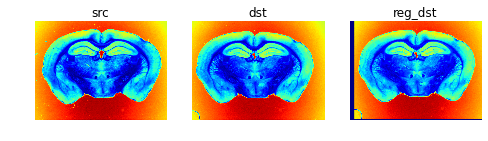

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
src = stack[2]
#tform = tf.AffineTransform(scale=(1, 1), translation=(-50, 0))
dst = stack[1]
reg_dst = reg(src, dst)
ax[0].imshow(src)
ax[0].axis('off')
ax[0].set_title('src')
ax[1].imshow(dst)
ax[1].axis('off')
ax[1].set_title('dst')
ax[2].imshow(reg_dst)
ax[2].axis('off')
ax[2].set_title('reg_dst')

In [22]:
from skimage.morphology import skeletonize
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt

# an empty image
image = np.zeros((400, 400))

# foreground object 1
image[10:-10, 10:100] = 1
image[-100:-10, 10:-10] = 1
image[10:-10, -100:-10] = 1

# foreground object 2
rs, cs = draw.line(250, 150, 10, 280)
for i in range(10):
    image[rs + i, cs] = 1
rs, cs = draw.line(10, 150, 250, 280)
for i in range(20):
    image[rs + i, cs] = 1

image
# foreground object 3
ir, ic = np.indices(image.shape)
circle1 = (ic - 135)**2 + (ir - 150)**2 < 30**2
circle2 = (ic - 135)**2 + (ir - 150)**2 < 20**2
image[circle1] = 1
image[circle2] = 0

# perform skeletonization
skeleton = skeletonize(image)

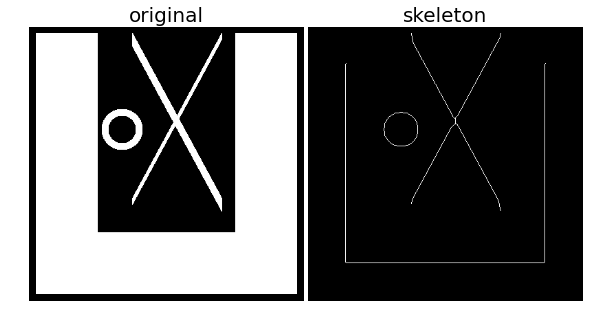

In [21]:
# display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('original', fontsize=20)

ax2.imshow(skeleton, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('skeleton', fontsize=20)

fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.98,
                    bottom=0.02, left=0.02, right=0.98)